<a href="https://colab.research.google.com/github/jinsel/Pruning-the-Neural-Networks/blob/master/Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Purning**
Pruning is one of the methods for inference to efficiently produce models smaller in size, more memory-efficient, more power-efficient and faster at inference with minimal loss in accuracy, other such techniques being weight sharing and quantization. Out of several aspects that deep learning takes as an inspiration from the area of Neuroscience. Pruning in deep learning is also a biologically inspired.

## Purning helps to solve the problems of:
1) Model are getting larger<br>
2) Speed of the machine if you use CPU<br>
3) Energy Efficiency (Memory Usage)


## Setup the notebook (for Colab)

**Enable the GPU with**: Runtime > Change runtime type > Hardware accelator and make sure GPU is selected.

In [0]:
#for tensorboard in google colab
!pip install -q tf-nightly-2.0-preview

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
#importing the required libraries 

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime, os
import tempfile
from shutil import copyfile,move 
import h5py
import numpy as np
import zipfile
import glob
from numpy import linalg as LA
from scipy.stats import rankdata


In [0]:
#Data Preprocessing
#download the MNIST datasets from keras.datasets.mnist
batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

train_data = train_data.reshape(train_data.shape[0], img_rows*img_cols)
test_data = test_data.reshape(test_data.shape[0], img_rows* img_cols)
input_shape = (img_rows* img_cols, )


train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_data /= 255
test_data /= 255
print('train_data shape:', train_data.shape)
print(train_data.shape[0], 'train samples')
print(test_data.shape[0], 'test samples')

# convert class vectors to binary class matrices
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

print("num_classes:", num_classes)

train_data shape: (60000, 784)
60000 train samples
10000 test samples
num_classes: 10


## Before the Puring

In [0]:
#creating the Simple Neural Networks without using CNN

#input size 784
#activation function for Networks: ReLu function
#for the final output layer we use Softmax activation function

model=tf.keras.Sequential([
    tf.keras.layers.Dense(1000,input_shape=input_shape),
    tf.keras.layers.Dense(1000,activation=tf.nn.relu),
    tf.keras.layers.Dense(500,activation=tf.nn.relu),
    tf.keras.layers.Dense(200,activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes,activation=tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              785000    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2010      
Total params: 2,388,710
Trainable params: 2,388,710
Non-trainable params: 0
_________________________________________________________________


In [0]:
#for tensorboard usage
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#compling the model
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

model.fit(train_data, train_labels,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          callbacks=[tensorboard_callback],
          validation_data=(test_data, test_labels))

score = model.evaluate(test_data, test_labels, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 29s 488us/sample - loss: 0.2173 - accuracy: 0.9335 - val_loss: 0.1172 - val_accuracy: 0.9627
Epoch 2/10
60000/60000 [==============================] - 28s 462us/sample - loss: 0.1022 - accuracy: 0.9694 - val_loss: 0.1008 - val_accuracy: 0.9703
Epoch 3/10
60000/60000 [==============================] - 28s 470us/sample - loss: 0.0833 - accuracy: 0.9753 - val_loss: 0.0913 - val_accuracy: 0.9709
Epoch 4/10
60000/60000 [==============================] - 27s 443us/sample - loss: 0.0665 - accuracy: 0.9797 - val_loss: 0.0805 - val_accuracy: 0.9761
Epoch 5/10
60000/60000 [==============================] - 27s 454us/sample - loss: 0.0616 - accuracy: 0.9816 - val_loss: 0.1031 - val_accuracy: 0.9720
Epoch 6/10
60000/60000 [==============================] - 28s 466us/sample - loss: 0.0481 - accuracy: 0.9849 - val_loss: 0.1022 - val_accuracy: 0.9713
Epoch 7/10
60000/60000 [====================

In [0]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 628), started 2:18:44 ago. (Use '!kill 628' to kill it.)

In [0]:
#Save model
_, model_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, model_file, include_optimizer=False)

## **Here we are comparing two different Purning techniques<br> <br>**
1) **Weight Pruning** <br> 
2) **Unit/Neuron Pruning**

#### Weight pruning
1)Set individual weights in the weight matrix to zero. This corresponds to deleting connections.<br>

2)Here, to achieve *sparsity* of k% we rank the individual weights in weight matrix W according to their magnitude, and then set to zero the smallest k%.

Tensors with several values set to zero can be considered *sparse*. This results in important benefits:
* *Compression*. Sparse tensors are amenable to compression by only keeping the non-zero values and their corresponding coordinates.
* *Speed*. Sparse tensors allow us to skip otherwise unnecessary computations involving the zero values.

#### Unit/Neuron Pruning
1)Set entire columns to zero in the weight matrix to zero, in effect deleting the corresponding output neuron.<br>

2)Here to achieve *sparsity* of k% we rank the columns of a weight matrix according to their *L2-norm* and delete the smallest k%.


### Weight Purning

In [0]:
#Prune away(set to zero) the k% of weights using weight pruning for k in [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
for k in [.0 ,.25, .50, .60, .70, .80, .90, .95, .97, .99]:
  copyfile(model_file,"/tmp/orig.h5")
  f = h5py.File("/tmp/orig.h5",'r+')
  ranks = {}
  for l in list(f['model_weights'])[:-1]:
#   for l in ['dense', 'dense_1', 'dense_2', 'dense_3']:
    data = f['model_weights'][l][l]['kernel:0']
    w = np.array(data)
    ranks[l]=(rankdata(np.abs(w),method='dense') - 1).astype(int).reshape(w.shape)
    lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
    ranks[l][ranks[l]<=lower_bound_rank] = 0
    ranks[l][ranks[l]>lower_bound_rank] = 1
    w = w*ranks[l]
    data[...] = w
  f.close()
  move("/tmp/orig.h5","/tmp/weight_"+str(k)+".h5")

### Unit/Neuron Purning

In [0]:
#Prune away(set to zero) the k% of weights using Unit/Neuron pruning for k in [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
for k in [.0, .25, .50, .60, .70, .80, .90, .95, .97, .99]:
  copyfile(model_file,"/tmp/orig.h5")
  f = h5py.File("/tmp/orig.h5",'r+')
  ranks = {}
  for l in list(f['model_weights'])[:-1]:
#   for l in ['dense', 'dense_1', 'dense_2', 'dense_3']:
    data = f['model_weights'][l][l]['kernel:0']
    w = np.array(data)
    norm = LA.norm(w,axis=0)
    norm = np.tile(norm,(w.shape[0],1))
    ranks[l] = (rankdata(norm,method='dense') - 1).astype(int).reshape(norm.shape)
    lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
    ranks[l][ranks[l]<=lower_bound_rank] = 0
    ranks[l][ranks[l]>lower_bound_rank] = 1
    w = w*ranks[l]
    data[...] = w
  f.close()
  move("/tmp/orig.h5","/tmp/neuron"+str(k)+".h5")

In [0]:
#we can check the decreasing in the accuracy while droping down the parameters

files_weights = glob.glob('/tmp/weight*.h5')
files_weights.sort()
files_neuron = glob.glob('/tmp/neuron*.h5')
files_neuron.sort()
  
accuracy_weights = []
accuracy_neurons = []

for f in files_weights:
  restored_model = tf.keras.models.load_model(f,compile=False)
  restored_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])
  score = restored_model.evaluate(test_data, test_labels, verbose=0)
  fl = h5py.File(f)
  params = 0
  for l in list(fl['model_weights']):
    val = np.array(fl['model_weights'][l][l]['kernel:0'])
    params += val[val>0].shape[0]
  accuracy_weights.append(score[1])
  print('Params ',params)
  print('Model ',f)
  print('Test accuracy:', score[1])


for f in files_neuron:
  restored_model = tf.keras.models.load_model(f,compile=False)
  restored_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])
  score = restored_model.evaluate(test_data,test_labels, verbose=0)
  fl = h5py.File(f)
  params = 0
  for l in list(fl['model_weights']):
      val = np.array(fl['model_weights'][l][l]['kernel:0'])
      params += val[val>0].shape[0]
  accuracy_neurons.append(score[1])

Params  1137381
Model  /tmp/weight_0.0.h5
Test accuracy: 0.9755
Params  843203
Model  /tmp/weight_0.25.h5
Test accuracy: 0.9753
Params  551876
Model  /tmp/weight_0.5.h5
Test accuracy: 0.9753
Params  437212
Model  /tmp/weight_0.6.h5
Test accuracy: 0.9751
Params  324536
Model  /tmp/weight_0.7.h5
Test accuracy: 0.9721
Params  213664
Model  /tmp/weight_0.8.h5
Test accuracy: 0.9559
Params  104975
Model  /tmp/weight_0.9.h5
Test accuracy: 0.718
Params  52362
Model  /tmp/weight_0.95.h5
Test accuracy: 0.114
Params  31538
Model  /tmp/weight_0.97.h5
Test accuracy: 0.0974
Params  10963
Model  /tmp/weight_0.99.h5
Test accuracy: 0.0974


In [0]:
#Saving the Pruned model
_, new_pruned_keras_file = tempfile.mkstemp('.h5')
print('Saving pruned model to: ', new_pruned_keras_file)
tf.keras.models.save_model(restored_model, new_pruned_keras_file, 
                        include_optimizer=False)

Saving pruned model to:  /tmp/tmp2lmjqq48.h5


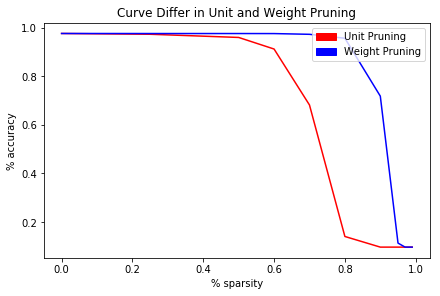

In [0]:
#plotting the graph between accuracy and sparsity of Weight Pruning and Unit Pruning
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.constrained_layout.use'] = True
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
red_patch = mpatches.Patch(color='red', label='Unit Pruning')
blue_patch = mpatches.Patch(color='blue',label='Weight Pruning')
plt.legend(handles=[red_patch,blue_patch],loc='upper right')
plt.plot([.0, .25, .50, .60, .70, .80, .90, .95, .97, .99],accuracy_neurons,color='red')
plt.plot([.0, .25, .50, .60, .70, .80, .90, .95, .97, .99],accuracy_weights,color='blue')
plt.title("Curve Differ in Unit and Weight Pruning")
plt.show()

In [0]:
#Compare the size of the unpruned vs. pruned model after compression

pruned_keras_files = files_neuron+files_weights


for pruned_keras_file in pruned_keras_files:
  _, zip2 = tempfile.mkstemp('.zip') 
  with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(pruned_keras_file)
  print("Size of the pruned model before compression: %.2f Mb" % 
        (os.path.getsize(pruned_keras_file) / float(2**20)))
  print("Size of the pruned model after compression: %.2f Mb" % 
        (os.path.getsize(zip2) / float(2**20)))
  
  

Size of the pruned model before compression: 9.13 Mb
Size of the pruned model after compression: 8.44 Mb
Size of the pruned model before compression: 9.13 Mb
Size of the pruned model after compression: 7.08 Mb
Size of the pruned model before compression: 9.13 Mb
Size of the pruned model after compression: 5.29 Mb
Size of the pruned model before compression: 9.13 Mb
Size of the pruned model after compression: 4.51 Mb
Size of the pruned model before compression: 9.13 Mb
Size of the pruned model after compression: 3.67 Mb
Size of the pruned model before compression: 9.13 Mb
Size of the pruned model after compression: 2.76 Mb
Size of the pruned model before compression: 9.13 Mb
Size of the pruned model after compression: 1.78 Mb
Size of the pruned model before compression: 9.13 Mb
Size of the pruned model after compression: 1.25 Mb
Size of the pruned model before compression: 9.13 Mb
Size of the pruned model after compression: 1.02 Mb
Size of the pruned model before compression: 9.13 Mb
Si

## Observation after this research
### **Q) What intresting insights did you find?<br>**

After this experiment of Pruning the networks I find that if we Pruned so much in the network then the accuracy drop will be incresed so fast as you can see the *decreasing in the accuracy while droping down the parameters* and also by pruned the networks its compressed the networks which helps in the optimise the space of system.
Not only the saving the space but we can also use this to mobile device and trained on CPU too.

### **Q) Do the curves differ?<br>**

Yes, the curves between the *Weights Pruning and the Unit Pruning*, there has an curves different.<br>
For **Unit Pruning**, the accuracy drop start after the *50% of sparsity* and ***around 60% to 80% sparsity*** the the accuracy drop is dramatically decreased. That's means the after the **50% of Sparsity the accuracy will drop down**<br>

For **Weight Pruning**, the accuracy drop start after the ***85% of sparsity***<br>

So from above observation, we can say that the more than 60% of sparisty in neural networks are not good for accuray

### **Q) Do you have any hypotheses as to why we are able to delete so much of the network without hurting performance.<br>**

I think because the features in neurons are repeating with each others, so by deleting the networks it does not effect the accuracy of the model.